In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Loan_Default.csv'

import pandas as pd
df = pd.read_csv(file_path)


In [ ]:
import missingno as msno
msno.heatmap(df, labels = True)

In [ ]:
df.head()

,,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [ ]:
df = df.drop(columns=[ 'year','Security_Type'])

removing outliers

In [ ]:
def remove_outliers(df, column):
    q_25 = df[column].quantile(0.25)
    q_75 = df[column].quantile(0.75)
    range = q_75-q_25
    lower_bound = q_25 - 1.5*range
    upper_bound = q_75 + 1.5*range
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'loan_amount')
df = remove_outliers(df, 'income')

In [ ]:
len(df)

37607

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
numerical_cols = ['loan_amount', 'rate_of_interest', 'Interest_rate_spread',
                  'Upfront_charges', 'term', 'property_value', 'income',
                  'Credit_Score', 'LTV', 'dtir1','Status']
categorical_cols = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
                    'loan_purpose', 'Credit_Worthiness', 'open_credit',
                    'business_or_commercial', 'Neg_ammortization', 'interest_only',
                    'lump_sum_payment', 'construction_type', 'occupancy_type',
                    'Secured_by', 'credit_type',
                    'co-applicant_credit_type' , 'submission_of_application',
                    'Region']


num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

Encoding


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))


In [ ]:
age_mapping = {
    '<25': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-64': 4,
    '65-74': 5,
    '>74': 6
}              # Mapping age in increasing order

df['age'] = df['age'].map(age_mapping)
df['total_units'] = df['total_units'].str.extract('(\d+)').astype(float)

In [ ]:
df_numerical = df[numerical_cols + ['age', 'total_units']].reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
df_processed = pd.concat([df_numerical, encoded_df], axis=1)
df_processed.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,...,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south
0,116500.0,3.99,0.4125,2852.88,360.0,118000.0,1740.0,758.0,98.728814,45.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,206500.0,3.99,0.4125,2852.88,360.0,408000.0,4980.0,552.0,74.641577,39.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,406500.0,4.56,0.2000,595.00,360.0,508000.0,9480.0,834.0,80.019685,46.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,456500.0,4.25,0.6810,2852.88,360.0,658000.0,11880.0,587.0,69.376900,42.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,696500.0,4.00,0.3042,0.00,360.0,758000.0,10440.0,602.0,91.886544,39.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Checking for NaN values in df_processed
nan_counts = df_processed.isna().sum()
print(nan_counts)

if nan_counts.any():
    print("NaN values exist in the DataFrame.")
else:
    print("No NaN values found in the DataFrame.")


loan_amount                           0
rate_of_interest                      0
Interest_rate_spread                  0
Upfront_charges                       0
term                                  0
property_value                        0
income                                0
Credit_Score                          0
LTV                                   0
dtir1                                 0
Status                                0
age                                   0
total_units                           0
loan_limit_cf                         0
loan_limit_ncf                        0
Gender_Female                         0
Gender_Joint                          0
Gender_Male                           0
Gender_Sex Not Available              0
approv_in_adv_nopre                   0
approv_in_adv_pre                     0
loan_type_type1                       0
loan_type_type2                       0
loan_type_type3                       0
loan_purpose_p1                       0


In [ ]:
df_processed.columns

Index(['loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score',
       'LTV', 'dtir1', 'Status', 'age', 'total_units', 'loan_limit_cf',
       'loan_limit_ncf', 'Gender_Female', 'Gender_Joint', 'Gender_Male',
       'Gender_Sex Not Available', 'approv_in_adv_nopre', 'approv_in_adv_pre',
       'loan_type_type1', 'loan_type_type2', 'loan_type_type3',
       'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3',
       'loan_purpose_p4', 'Credit_Worthiness_l1', 'Credit_Worthiness_l2',
       'open_credit_nopc', 'open_credit_opc', 'business_or_commercial_b/c',
       'business_or_commercial_nob/c', 'Neg_ammortization_neg_amm',
       'Neg_ammortization_not_neg', 'interest_only_int_only',
       'interest_only_not_int', 'lump_sum_payment_lpsm',
       'lump_sum_payment_not_lpsm', 'construction_type_mh',
       'construction_type_sb', 'occupancy_type_ir', 'occupancy_type_pr',
       'occupancy_type_sr', 'Secur

In [ ]:
len(df_processed.columns)

59

In [ ]:
df.head(10)

,,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Status,dtir1
0,24890,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500.0,...,1740.0,EXP,758.0,CIB,1,to_inst,98.728814,south,1.0,45.0
1,24891,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500.0,...,4980.0,EQUI,552.0,EXP,4,to_inst,74.641577,North,1.0,39.0
2,24892,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500.0,...,9480.0,EXP,834.0,CIB,2,to_inst,80.019685,south,0.0,46.0
3,24893,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500.0,...,11880.0,EXP,587.0,CIB,3,not_inst,69.376900,North,0.0,42.0
4,24894,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500.0,...,10440.0,CRIF,602.0,EXP,1,not_inst,91.886544,North,0.0,39.0
5,24895,cf,Joint,pre,type1,p1,l1,nopc,nob/c,706500.0,...,10080.0,EXP,864.0,EXP,2,not_inst,70.089286,North,0.0,40.0
6,24896,cf,Joint,pre,type1,p3,l1,nopc,nob/c,346500.0,...,5040.0,EXP,860.0,EXP,4,to_inst,79.109589,North,0.0,44.0
7,24897,cf,Female,nopre,type1,p4,l1,nopc,nob/c,266500.0,...,3780.0,CIB,863.0,CIB,4,to_inst,86.525974,North,0.0,42.0
8,24898,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,376500.0,...,5580.0,CIB,580.0,EXP,4,to_inst,78.765690,central,0.0,44.0
9,24899,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,436500.0,...,6720.0,CIB,788.0,EXP,4,to_inst,63.444767,south,0.0,30.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
Y=df_processed['Status']
X=df_processed.drop(columns=['Status'])

In [ ]:
print(df_processed.columns.tolist())
print(df_processed['Status'].value_counts())


['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1', 'Status', 'age', 'total_units', 'loan_limit_cf', 'loan_limit_ncf', 'Gender_Female', 'Gender_Joint', 'Gender_Male', 'Gender_Sex Not Available', 'approv_in_adv_nopre', 'approv_in_adv_pre', 'loan_type_type1', 'loan_type_type2', 'loan_type_type3', 'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4', 'Credit_Worthiness_l1', 'Credit_Worthiness_l2', 'open_credit_nopc', 'open_credit_opc', 'business_or_commercial_b/c', 'business_or_commercial_nob/c', 'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg', 'interest_only_int_only', 'interest_only_not_int', 'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm', 'construction_type_mh', 'construction_type_sb', 'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr', 'Secured_by_home', 'Secured_by_land', 'credit_type_CIB', 'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_

In [ ]:
import pandas as pd

target_column = 'Status'

correlations = df_processed.corr()

target_corr = correlations[target_column].abs().sort_values(ascending=False)

# Show top correlated features with 'Status'
print(target_corr)

low_corr_features = target_corr[target_corr < 0.05].index

low_corr_features = low_corr_features[low_corr_features != 'Credit_Score']

# Drop the low correlation features except 'Credit_Score'
df_processed = df_processed.drop(columns=low_corr_features)

# Show the updated DataFrame
print(df_processed.head())


Status                                1.000000
credit_type_EQUI                      0.600361
lump_sum_payment_lpsm                 0.178390
lump_sum_payment_not_lpsm             0.178390
co-applicant_credit_type_CIB          0.164973
co-applicant_credit_type_EXP          0.164973
Neg_ammortization_not_neg             0.159974
Neg_ammortization_neg_amm             0.159974
credit_type_CIB                       0.153545
income                                0.142366
credit_type_CRIF                      0.132620
loan_type_type1                       0.123903
submission_of_application_to_inst     0.121744
submission_of_application_not_inst    0.121744
credit_type_EXP                       0.120455
property_value                        0.110671
LTV                                   0.100940
business_or_commercial_nob/c          0.100082
business_or_commercial_b/c            0.100082
loan_type_type2                       0.100082
rate_of_interest                      0.094376
Upfront_charg

In [ ]:
original_columns = df.columns
processed_columns = df_processed.columns

dropped_columns = [col for col in original_columns if col not in processed_columns]
print("Dropped columns:", dropped_columns)


Dropped columns: [' ', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']


In [ ]:
# Print the columns that remain in the updated DataFrame
print("Remaining columns in the DataFrame:")
print(df_processed.columns.tolist())


Remaining columns in the DataFrame:
['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1', 'Status', 'Gender_Joint', 'loan_type_type1', 'loan_type_type2', 'loan_type_type3', 'business_or_commercial_b/c', 'business_or_commercial_nob/c', 'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg', 'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm', 'credit_type_CIB', 'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_EXP', 'co-applicant_credit_type_CIB', 'co-applicant_credit_type_EXP', 'submission_of_application_not_inst', 'submission_of_application_to_inst']


Feature correlations with 'Status':
 Status                                1.000000
credit_type_EQUI                      0.600361
lump_sum_payment_lpsm                 0.178390
lump_sum_payment_not_lpsm             0.178390
co-applicant_credit_type_CIB          0.164973
co-applicant_credit_type_EXP          0.164973
Neg_ammortization_not_neg             0.159974
Neg_ammortization_neg_amm             0.159974
credit_type_CIB                       0.153545
income                                0.142366
credit_type_CRIF                      0.132620
loan_type_type1                       0.123903
submission_of_application_to_inst     0.121744
submission_of_application_not_inst    0.121744
credit_type_EXP                       0.120455
property_value                        0.110671
LTV                                   0.100940
business_or_commercial_nob/c          0.100082
business_or_commercial_b/c            0.100082
loan_type_type2                       0.100082
rate_of_interest       

In [ ]:
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline

# Create a pipeline with just scaling and the model
pipeline = SkPipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Set up proper cross-validation that applies SMOTE only to the training folds
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use custom SMOTE handling in cross-validation
results = cross_validate(pipeline, X, Y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])


In [ ]:
print(results)

{'fit_time': array([6.02603483, 4.81877184, 5.35279322, 5.43638873, 4.86563444]), 'score_time': array([0.17281866, 0.18295646, 0.23354506, 0.17532229, 0.18163896]), 'test_accuracy': array([0.87888859, 0.87942037, 0.87807472, 0.87501662, 0.88086691]), 'test_precision': array([0.92347826, 0.92819615, 0.9237511 , 0.91843972, 0.93106457]), 'test_recall': array([0.56339523, 0.56233422, 0.55944798, 0.54989384, 0.5663482 ]), 'test_f1': array([0.69983526, 0.7003634 , 0.6968595 , 0.68791501, 0.70429043])}


In [ ]:
# # Train a standard RandomForest on the full dataset to check feature importance
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_resampled, y_resampled)

# # Get feature importance
# feature_importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': rf.feature_importances_
# }).sort_values('Importance', ascending=False)

# print(feature_importance)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Split into train and test to evaluate in more detail
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, stratify=Y, random_state=42)

# Fit the pipeline on train data
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))


Confusion Matrix:
[[7046    0]
 [   0 2356]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7046
         1.0       1.00      1.00      1.00      2356

    accuracy                           1.00      9402
   macro avg       1.00      1.00      1.00      9402
weighted avg       1.00      1.00      1.00      9402

ROC-AUC Score: 1.0


In [ ]:
# Check correlations with the target
correlations = df_processed.corr()
target_corr = correlations['Status'].abs().sort_values(ascending=False)
print(target_corr)


Status                        1.000000
credit_type_EQUI              0.600361
credit_type_CIB               0.153545
income                        0.142366
loan_type_type1               0.123903
credit_type_EXP               0.120455
property_value                0.110671
LTV                           0.100940
business_or_commercial_b/c    0.100082
loan_type_type2               0.100082
dtir1                         0.073869
loan_amount                   0.072664
Gender_Joint                  0.069139
Credit_Score                  0.002663
Name: Status, dtype: float64


In [ ]:
from sklearn.model_selection import cross_validate

# Use cross_validate to evaluate multiple metrics
cv_results = cross_validate(pipeline, X, Y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# Print the results
print("Cross-validation results:")
print("Accuracy:", cv_results['test_accuracy'])
print("Precision:", cv_results['test_precision'])
print("Recall:", cv_results['test_recall'])
print("F1-score:", cv_results['test_f1'])
print("ROC-AUC:", cv_results['test_roc_auc'])

# Calculate the average scores
avg_accuracy = np.mean(cv_results['test_accuracy'])
avg_precision = np.mean(cv_results['test_precision'])
avg_recall = np.mean(cv_results['test_recall'])
avg_f1 = np.mean(cv_results['test_f1'])
avg_roc_auc = np.mean(cv_results['test_roc_auc'])

print("\nAverage scores:")
print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-score: {avg_f1:.4f}")
print(f"ROC-AUC: {avg_roc_auc:.4f}")


Cross-validation results:
Accuracy: [0.87928742 0.88314278 0.8730222  0.87661215 0.87927137]
Precision: [0.92738408 0.93362069 0.91142604 0.91783217 0.92657343]
Recall: [0.56233422 0.57453581 0.54617834 0.55732484 0.5626327 ]
F1-score: [0.7001321  0.71133005 0.68304016 0.69352708 0.7001321 ]
ROC-AUC: [0.84009808 0.83663978 0.83210764 0.84240179 0.84632068]

Average scores:
Accuracy: 0.8783
Precision: 0.9234
Recall: 0.5606
F1-score: 0.6976
ROC-AUC: 0.8395


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Print the shape of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (30085, 58)
X_test shape: (7522, 58)
y_train shape: (30085,)
y_test shape: (7522,)


**Logistic Regression**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform
import numpy as np

# Pipeline: StandardScaler + LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=500,
        random_state=42
    ))
])

# Parameter distribution for 'C' (regularization strength)
param_dist = {
    'clf__C': loguniform(1e-3, 1e2)
}

# Stratified 3-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV setup
random_search_lr = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=3,                  # Small number for fast tuning
    scoring='f1',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit to training data
random_search_lr.fit(X_train, y_train)

# Get best model from pipeline
lr_best = random_search_lr.best_estimator_.named_steps['clf']

# Predict on test data
lr_pred_best = random_search_lr.best_estimator_.predict(X_test)

# Evaluation
print("Best Params:", random_search_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, lr_pred_best))
print("F1 Score:", f1_score(y_test, lr_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred_best))




Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'clf__C': np.float64(4.5705630998014515)}
Accuracy: 0.8746344057431534
F1 Score: 0.6880582203109494
Confusion Matrix:
[[5539   98]
 [ 845 1040]]


In [ ]:
pip install shap

SHAP for logistic regression

<ipython-input-40-70d4e1605c07>:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled_df)


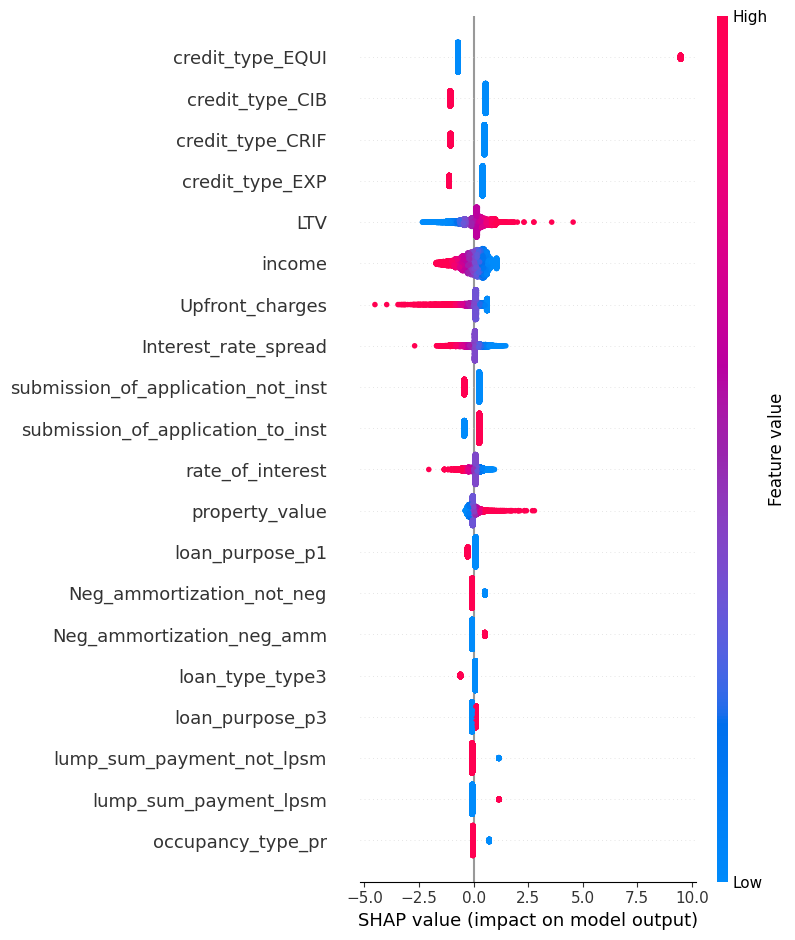

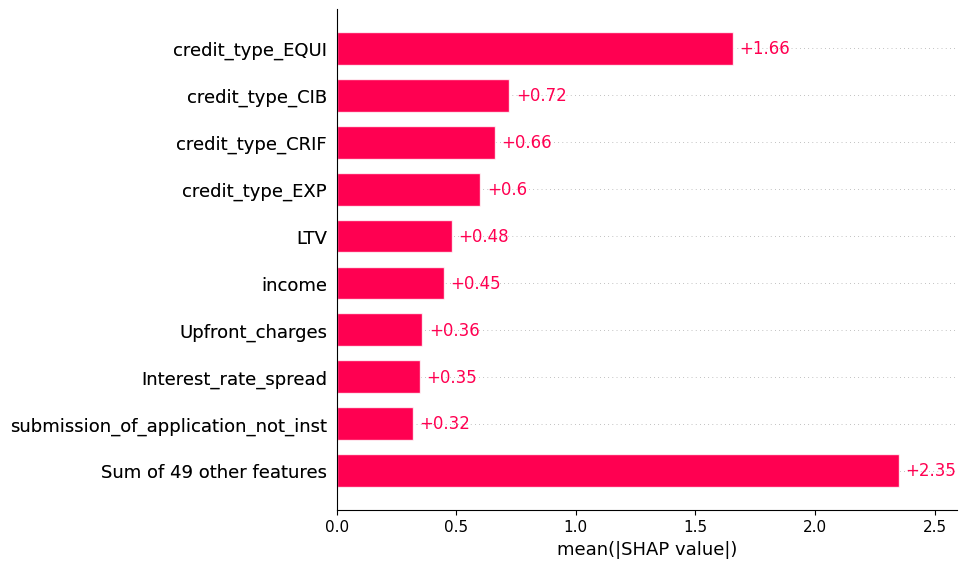

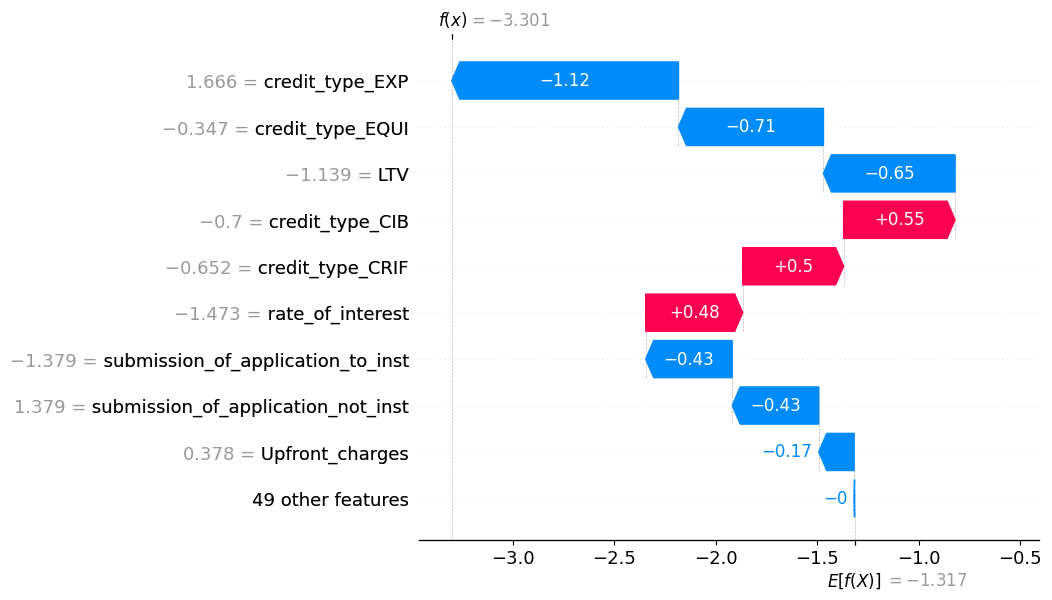

In [ ]:
import pandas as pd

# Save original feature names
feature_names = X_test.columns  # works only if X_test is a DataFrame

# Scale data
X_test_scaled = random_search_lr.best_estimator_.named_steps['scaler'].transform(X_test)

# Convert scaled data back to DataFrame with original column names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Run SHAP as before
explainer = shap.Explainer(lr_best, X_test_scaled_df)
shap_values = explainer(X_test_scaled_df)

# Summary plot with real feature names
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled_df)

# Bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values)

# Waterfall for a single prediction
plt.figure(figsize=(6, 4))
shap.plots.waterfall(shap_values[0])


**Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import randint, uniform  # for parameter distributions

# Step 1: Train the base Gradient Boosting Classifier (without scaling)
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Predicting the results
y_pred_gb = gb_clf.predict(X_test)

# Calculate accuracy and F1 score
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

# Print base model performance
print("Gradient Boosting - Accuracy:", accuracy_gb, "F1 Score:", f1_gb)

# Step 2: Hyperparameter tuning using RandomizedSearchCV
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 8)
}

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=20,                 # Number of random combinations to try
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the randomized search model
random_search_gb.fit(X_train, y_train)

# Get the best estimator
gb_best = random_search_gb.best_estimator_

# Predict using the optimized model
gb_pred = gb_best.predict(X_test)

# Calculate accuracy and F1 score for the optimized model
gb_accuracy_optimized = accuracy_score(y_test, gb_pred)
gb_f1_optimized = f1_score(y_test, gb_pred)

# Print the best hyperparameters and performance
print("Best hyperparameters for Gradient Boosting:", random_search_gb.best_params_)
print("Gradient Boosting (Optimized) - Accuracy:", gb_accuracy_optimized, "F1 Score:", gb_f1_optimized)

# Optional: Classification report
print(classification_report(y_test, gb_pred))


Gradient Boosting - Accuracy: 0.8803509704865727 F1 Score: 0.7001998667554963
Best hyperparameters for Gradient Boosting: {'learning_rate': np.float64(0.08800932022121825), 'max_depth': 5, 'n_estimators': 124}
Gradient Boosting (Optimized) - Accuracy: 0.8826110077107152 F1 Score: 0.708099173553719
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      5637
         1.0       0.94      0.57      0.71      1885

    accuracy                           0.88      7522
   macro avg       0.91      0.78      0.82      7522
weighted avg       0.89      0.88      0.87      7522



**KNN Algorithm**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN classifier on the training data
print("Training KNN...")
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

# Make predictions on the test data (X_test)
y_pred_knn = knn_clf.predict(X_test)  # Predict on X_test, not X_train

# Evaluate the model's accuracy and F1 score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

# Print the results
print("KNN - Accuracy:", accuracy_knn)
print("KNN - F1 Score:", f1_knn)

# Hyperparameter tuning with GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='f1', cv=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Get the best estimator (optimized KNN model)
knn_best = grid_knn.best_estimator_

# Make predictions on the test data using the optimized model
knn_pred = knn_best.predict(X_test)

# Evaluate the optimized model's accuracy and F1 score
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

# Print the best hyperparameters and optimized model's performance
print("Best hyperparameters for KNN:", grid_knn.best_params_)
print("KNN (Optimized) - Accuracy:", knn_accuracy)
print("KNN (Optimized) - F1 Score:", knn_f1)


Training KNN...
KNN - Accuracy: 0.851103429938846
KNN - F1 Score: 0.6761133603238867
Best hyperparameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}
KNN (Optimized) - Accuracy: 0.8616059558628024
KNN (Optimized) - F1 Score: 0.7056827820186599


SHAP for KNN

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# If your model is not in a pipeline, you will need to scale X_test manually
# Assuming you've already fitted the scaler on the training data
scaler = StandardScaler()  # or use the scaler that was previously fitted
X_test_scaled = scaler.fit_transform(X_test)  # Scale the X_test data

# Convert the scaled data back to DataFrame with the correct feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 2. SHAP explanation using KernelExplainer for KNN (model-agnostic approach)
# Use 'predict_proba' for classification tasks
explainer = shap.KernelExplainer(knn_best.predict_proba, X_test_scaled_df)
shap_values = explainer.shap_values(X_test_scaled_df)

# 3. Set the figure size for the summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled_df)

# 4. Set the figure size for the bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values)

# 5. Set the figure size for the waterfall plot
plt.figure(figsize=(6, 4))
shap.plots.waterfall(shap_values[0])  # For the first instance in the test set


  0%|          | 0/7522 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import randint

# Step 1: Train the base Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predicting the results
y_pred_rf = rf_clf.predict(X_test)

# Calculate accuracy and F1 score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print base model performance
print("Random Forest - Accuracy:", accuracy_rf, "F1 Score:", f1_rf)

# Step 2: Hyperparameter tuning using RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,                  # Number of random combinations to try
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the randomized search model
random_search_rf.fit(X_train, y_train)

# Get the best estimator
rf_best = random_search_rf.best_estimator_

# Predict using the optimized model
rf_pred = rf_best.predict(X_test)

# Calculate accuracy and F1 score for the optimized model
rf_accuracy_optimized = accuracy_score(y_test, rf_pred)
rf_f1_optimized = f1_score(y_test, rf_pred)

# Print the best hyperparameters and performance
print("Best hyperparameters for Random Forest:", random_search_rf.best_params_)
print("Random Forest (Optimized) - Accuracy:", rf_accuracy_optimized, "F1 Score:", rf_f1_optimized)

# Optional: Classification report
print(classification_report(y_test, rf_pred))


SHAP FOR RANDOM FOREST

<ipython-input-33-11846422b0d9>:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x600 with 0 Axes>

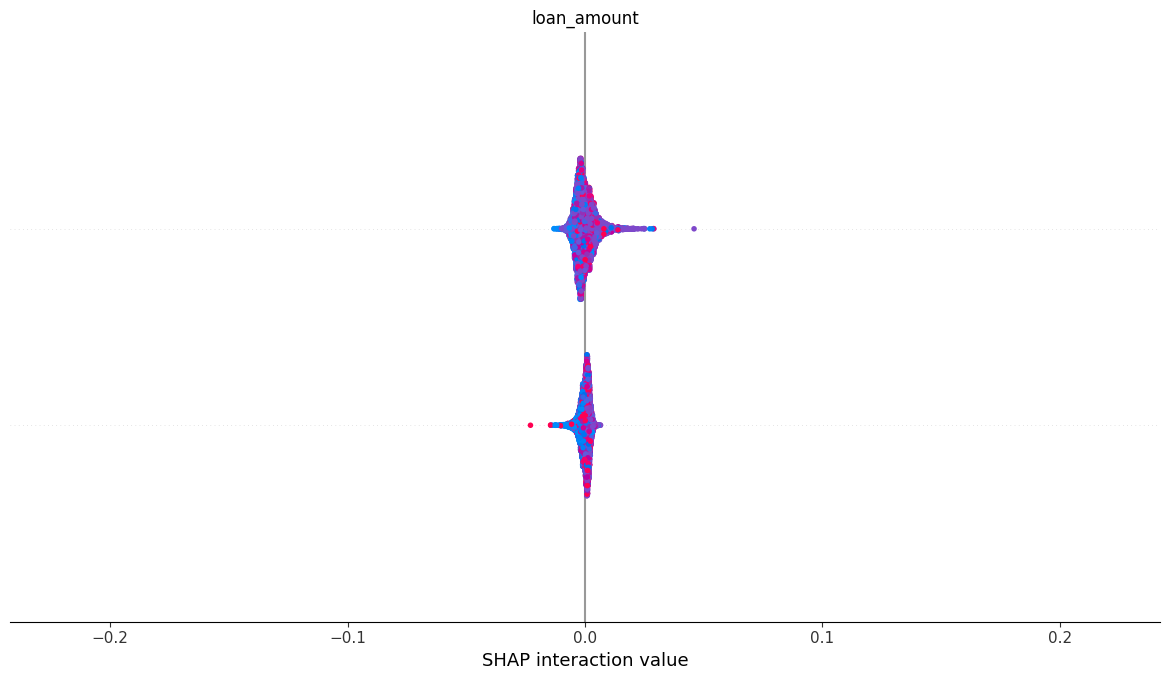

IndexError: list index out of range

<Figure size 1000x600 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# Use TreeExplainer
explainer = shap.Explainer(rf_best)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

# ✅ FIXED bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=20)

# Waterfall plot
plt.figure(figsize=(6, 4))
shap.plots.waterfall(shap_values[0])


In [ ]:
pip install shap

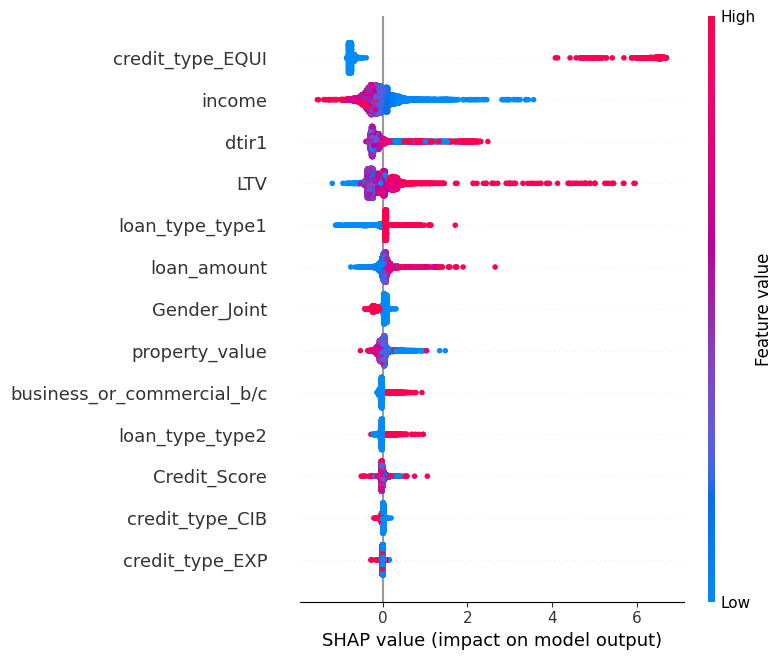

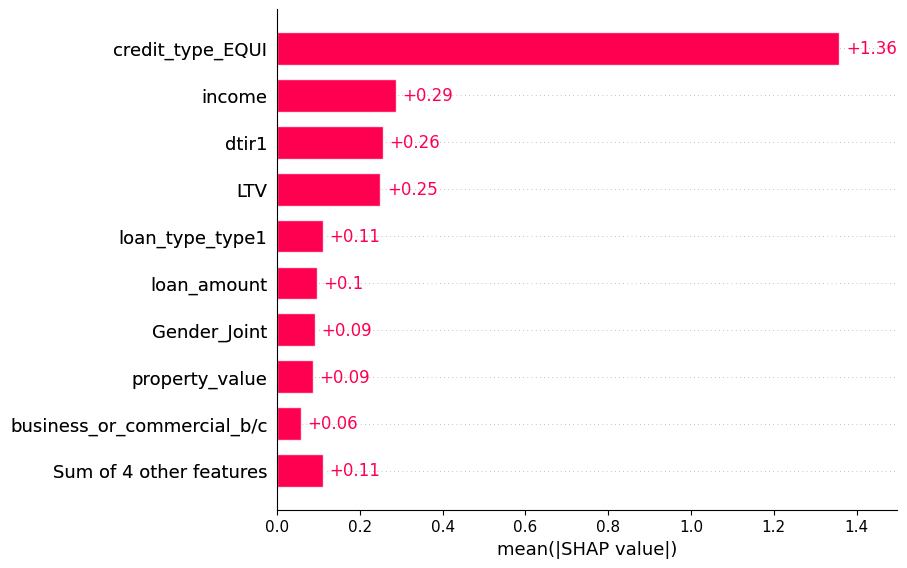

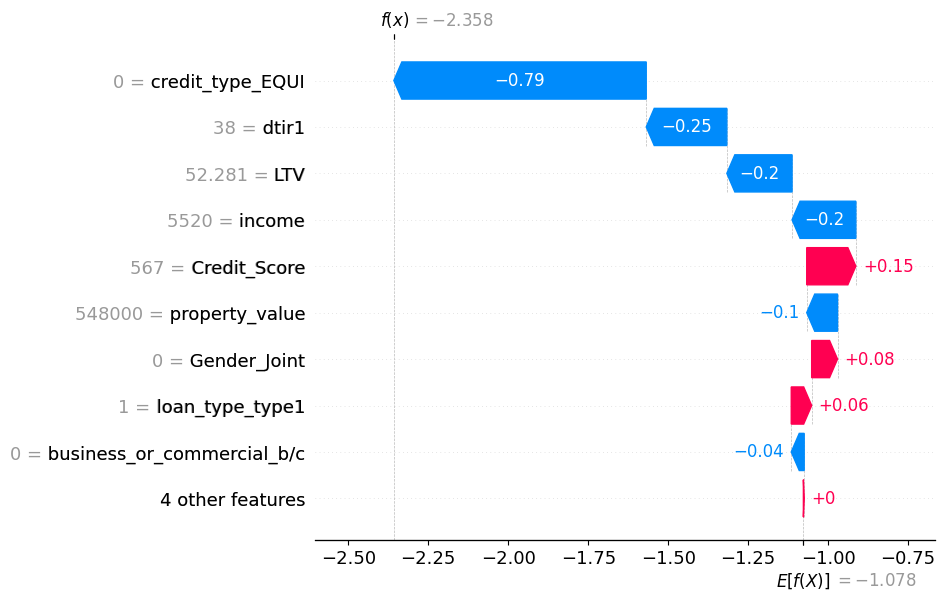

In [ ]:
import shap
import matplotlib.pyplot as plt

# Use TreeExplainer for tree-based models like GradientBoostingClassifier
explainer = shap.Explainer(gb_best)  # gb_best is your optimized Gradient Boosting model
shap_values = explainer(X_test)

# Set the figure size for the summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

# Set the figure size for the bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values)

# Set the figure size for the waterfall plot
plt.figure(figsize=(6, 4))
shap.plots.waterfall(shap_values[0])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, f1_score

# Define the parameter grid for RandomizedSearchCV (keeping it smaller)
param_dist = {
    'linearsvc__C': uniform(0.1, 5),           # Regularization parameter (smaller range)
    'linearsvc__max_iter': randint(1000, 3000),  # Max iterations for convergence (smaller range)
}

# Create a pipeline with StandardScaler and LinearSVC
svm_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(random_state=42)
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist,
    n_iter=10,                # Reduce the number of random combinations to try
    scoring='f1',             # Optimize for F1 score
    cv=3,                     # 3-fold cross-validation
    n_jobs=-1,                # Use all available CPUs
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for SVM:", random_search.best_params_)

# Evaluate on test data
y_pred_svm_best = random_search.best_estimator_.predict(X_test)
accuracy_svm_best = accuracy_score(y_test, y_pred_svm_best)
f1_svm_best = f1_score(y_test, y_pred_svm_best)

print("SVM (Optimized) - Accuracy:", accuracy_svm_best)
print("SVM (Optimized) - F1 Score:", f1_svm_best)


Best hyperparameters for SVM: {'linearsvc__C': np.float64(1.9727005942368125), 'linearsvc__max_iter': 1860}
SVM (Optimized) - Accuracy: 0.8568199946822653
SVM (Optimized) - F1 Score: 0.6000742666171556


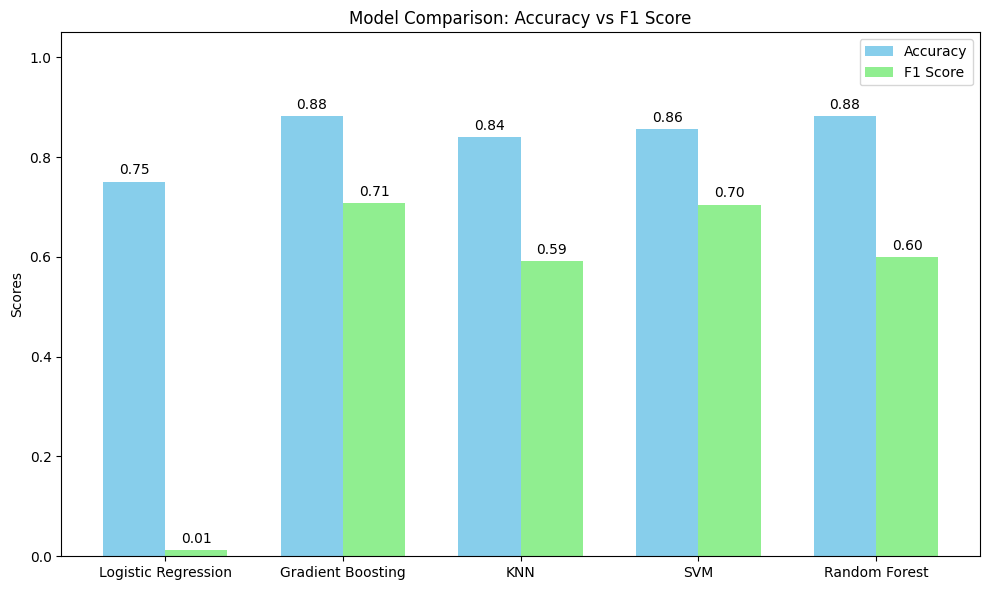

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'Gradient Boosting', 'KNN','SVM','Random Forest']

# Accuracy scores: [Base, Optimized]
accuracy_scores = [
    0.7509, gb_accuracy_optimized, knn_accuracy, accuracy_svm_best, rf_accuracy_optimized
]

# F1 scores: [Base, Optimized]
f1_scores = [
    0.0126, gb_f1_optimized, knn_f1,rf_f1_optimized,f1_svm_best
]

# Plotting
x = np.arange(len(models))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy bar
acc_bars = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')

# F1 Score bar
f1_bars = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightgreen')

# Labels and titles
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy vs F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate the bars with values
for bar in acc_bars + f1_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
